<font size='6'><b>E-commerce Analytics</b></font><br><br>
<font size='6'>Customer Clustering & Market Basket Analysis</font><br><br>

<font size='4'>Antonio Buzzelli</font><br>
<font size='4'>March 2023</font>

Dataset: https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business?sort=published


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


# Data: exploration & transformation


In [2]:
df = pd.read_csv('sales.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


In [3]:
df

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom
...,...,...,...,...,...,...,...,...
536345,C536548,12/1/2018,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany
536346,C536548,12/1/2018,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany
536347,C536548,12/1/2018,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany
536348,C536548,12/1/2018,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany


* TransactionNo (categorical): a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.
* Date (numeric): the date when each transaction was generated.
* ProductNo (categorical): a five or six-digit unique character used to identify a specific product.
* Product (categorical): product/item name.
* Price (numeric): the price of each product per unit in pound sterling (£).
* Quantity (numeric): the quantity of each product per transaction. Negative values related to cancelled transactions.
* CustomerNo (categorical): a five-digit unique number that defines each customer.
* Country (categorical): name of the country where the customer resides.

In [4]:
# Validating variable types
df['Date'] = pd.to_datetime(df['Date'])
df[['ProductNo', 'CustomerNo']] = df[['ProductNo', 'CustomerNo']].astype('object')

# Creating a `TotalPrice` colum
df['Amount'] = df['Quantity'] * df['Price']

## Returns

The most notable characteristic of this dataset is the presence of *returns*, represented by negative values in the `Quantity` variable. In this section we are going to gain insights on this feature to understand how to deal with it for further analysis.

In [5]:
# We create a boolean variable to identify if a product is returned or not
df['Return'] = np.where(df['Quantity'] < 0, 1, 0)

# Create a boolean variable to show if the product is within a broader order or not
df['SingleOrder'] = df.duplicated('TransactionNo').astype(int)
print(f"Percentage of products sold within a broader order: {1 - sum(df['SingleOrder']) / df.shape[0]}")

# Creating another `TotalPrice` column that takes into consideration returns (represented by -n values in the `Quantity` column).
df['AmountN'] = np.where(df['Amount'] < 0, 0, df['Amount'])

Percentage of products sold within a broader order: 0.043262794816817385


Do returned products (return-labelled observations) come in specific transactions or are they mixed with non-returned products? 

In [6]:
transactionReturned = df.loc[df['Return'] == 1, 'TransactionNo']
df[(df['Return'] == 0) & (df['TransactionNo'].isin(transactionReturned))]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Amount,Return,SingleOrder,AmountN


Returned products have specific transaction IDs (`TransactionNo`).

Do all returned-labelled observations begin with the letter 'C'?

In [7]:
np.all(np.char.startswith(transactionReturned.unique().astype(str), 'C'))

True

Comparing the total number of observations in which `TransactionNo` starts with 'C' with the total number of observations that have been precedently labelled as "returns":

In [8]:
return2 = np.where(df['TransactionNo'].str.startswith('C'), 1, 0)
print(df['Return'].sum())
print(return2.sum())

8585
8585


In [9]:
transno_c = df[df['TransactionNo'].str.slice(0, 1) == 'C']['TransactionNo'].str.slice(1)
df[df['TransactionNo'].isin(transno_c)]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Amount,Return,SingleOrder,AmountN


Transaction IDs for returned products are different from the IDs of non-returned products, and they begin with letter 'C'.

## Missing values

In [10]:
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

CustomerNo       0.000103
TransactionNo    0.000000
Date             0.000000
ProductNo        0.000000
ProductName      0.000000
Price            0.000000
Quantity         0.000000
Country          0.000000
Amount           0.000000
Return           0.000000
SingleOrder      0.000000
AmountN          0.000000
dtype: float64

In [11]:
nulls = df[df['CustomerNo'].isnull()]
nulls.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Amount,Return,SingleOrder,AmountN
6511,C581406,2019-12-08,46000M,Polyester Filler Pad 45x45cm,6.19,-240,NaN,United Kingdom,-1485.60,1,0,0.0
6512,C581406,2019-12-08,46000S,Polyester Filler Pad 40x40cm,6.19,-300,NaN,United Kingdom,-1857.00,1,1,0.0
90098,C575153,2019-11-08,22947,Wooden Advent Calendar Red,44.25,-1,NaN,United Kingdom,-44.25,1,0,0.0
102671,C574288,2019-11-03,22178,Victorian Glass Hanging T-Light,25.37,-1,NaN,United Kingdom,-25.37,1,0,0.0
117263,C573180,2019-10-28,23048,Set Of 10 Lanterns Fairy Light Star,14.50,-1,NaN,United Kingdom,-14.50,1,0,0.0


In [12]:
nulls['Return'].value_counts()

1    54
0     1
Name: Return, dtype: int64

Only `CustomerNo` variable has null vaues. They are most probably due to mistakes in data collection. Dropping them would be a mistake because we would loose account for those returned items.

# Exploratory analysis
## Evolution of volume of sales

In [77]:
bymonth = df.groupby(pd.Grouper(key='Date', freq='M')).agg(
    sold=('Amount','sum'), returned=('Amount', lambda x: sum(x[x < 0])),
    nunique=('TransactionNo', 'nunique')
    )
bymonth['sold_moving_avg'] = bymonth['sold'].rolling(window=3).mean()
bymonth['returned'] = bymonth['returned'].abs()
bymonth.index = bymonth.index.date
bymonth

,sold,returned,nunique,sold_moving_avg
2018-12-31,4234147.48,181268.04,1852,NaN
2019-01-31,3649506.42,910349.95,1327,NaN
2019-02-28,3299537.56,35479.62,1287,3.727730e+06
2019-03-31,4353308.78,45092.82,1722,3.767451e+06
2019-04-30,3416109.24,173388.64,1455,3.689652e+06
2019-05-31,4530850.36,48114.72,1938,4.100089e+06
2019-06-30,4410422.29,84308.52,1826,4.119127e+06
2019-07-31,4518347.92,75519.14,1687,4.486540e+06
2019-08-31,4614243.55,144112.47,1581,4.514338e+06
2019-09-30,6542706.30,85596.76,2117,5.225099e+06


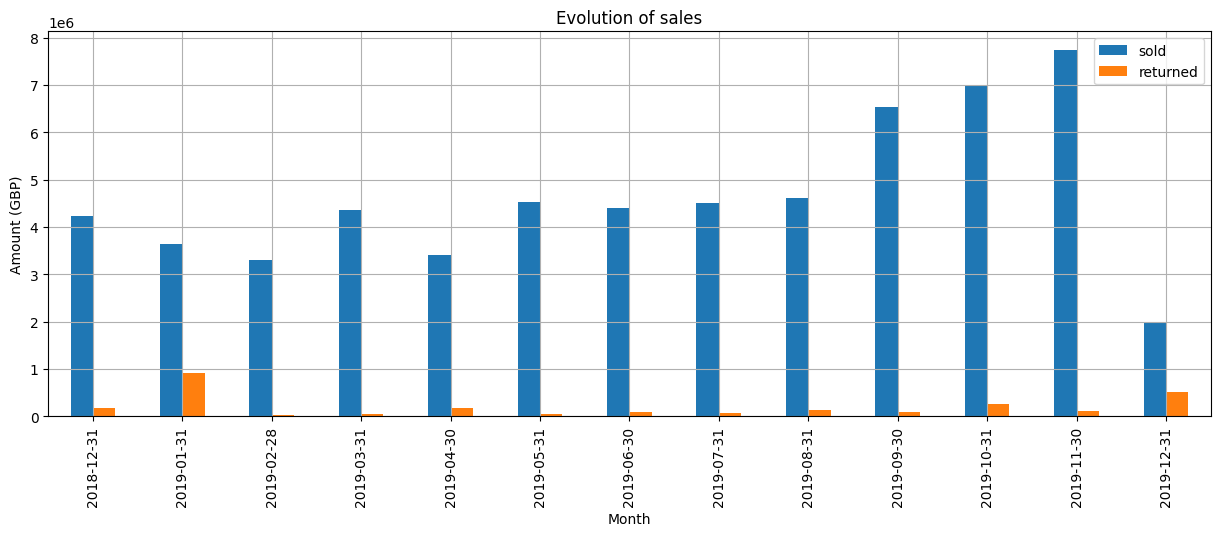

In [108]:
bymonth[['sold', 'returned']].plot.bar(figsize=(15,5))
plt.ylabel('Amount (GBP)')
plt.xlabel('Month')
plt.title("Evolution of sales")
plt.grid(True)
plt.legend()
plt.show()

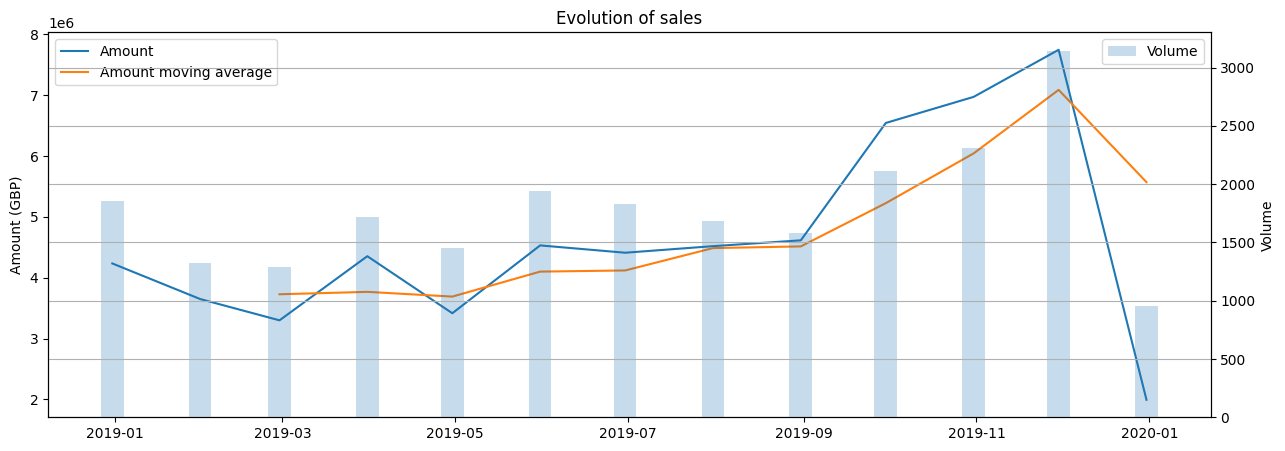

In [111]:
fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = plt.twinx()
ax1.plot(bymonth.index, bymonth['sold'], label='Amount')
ax1.plot(bymonth.index, bymonth['sold_moving_avg'], label='Amount moving average')
ax2.bar(bymonth.index, bymonth['nunique'], width=8, label='Volume', alpha=0.25)

ax1.set_ylabel('Amount (GBP)')
ax2.set_ylabel('Volume')
plt.xlabel('Month')
plt.title("Evolution of sales")
plt.grid(True)
ax1.legend()
ax2.legend()
plt.show()

## Country

In [ ]:
bycountry = df.groupby('Country').agg()

## Products

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
df['ProductName'].value_counts().head(50).plot(kind='bar', ax=ax)
plt.title("50 most sold products")
plt.show()